# 5 - Single Kramers chain analysis
Here we will be only looking at a single chain and what tools are available to plot the dynamics.

In [1]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate
from dilutebrowniandynamics.molecules.Kramers_chain import KramersChain

## Parameters definition

In [2]:
n_links = 100       # Number of segments in the Kramers chain

n_proc = 16         # Number of processor cores to use

output_file = 'outputs/sandpit'

## Initialise molecules
Here we just draw random vectors from a normal distribution and rescale to unit vectors. To do this with call `from_normal_distribution` constructor. 

In [3]:
# Starting vectors
molecule = KramersChain.from_normal_distribution(n_links, np.random.SeedSequence(2022))

We can plot this molecule using matplotlib 3d capabilities: firt we need to convert links to coordinates.

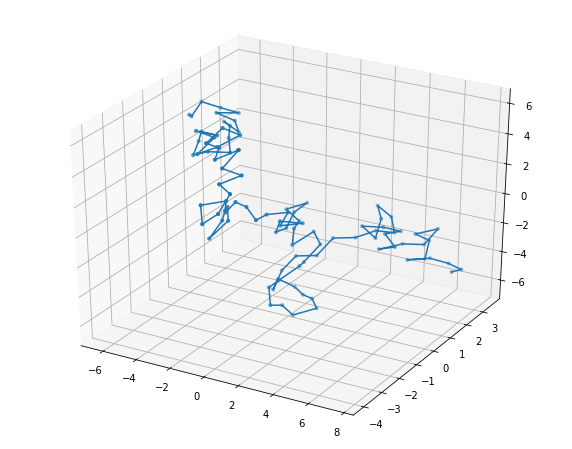

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 8]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xyz = molecule.coordinates
x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
ax.plot(x, y, z)
ax.scatter(x, y, z, s=10)

Or we can export the molecule to vtk format which can be read by Paraview.

In [5]:
molecule.save_vtk('outputs/vtk/example.vtk')

## Initial relaxation
Thermalisation step.

In [6]:
gradU = np.zeros((3, 3))
dt = .01           # Time step value (dimensionless)
n_steps = 2000        # Number of time steps to record
write_interval = 1

observables, molecule_out = simulate(molecule, gradU, dt, n_steps,
                                     write_interval=write_interval, full_trajectory=False, progress=True)

100%|██████████| 2000/2000 [00:02<00:00, 805.05it/s] 


## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We first define a callable `gradU` function for this scenario.

In [7]:
from scipy.interpolate import interp1d
t_base = [0, # Elongation starts at t = 0
          5] # Relaxation will start from t = 5
gradU_base = [np.diag([1, -.5, -.5]),
              np.zeros((3, 3))]
gradU = interp1d(t_base, gradU_base, axis=0, kind='previous', bounds_error=False, 
                 fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)

In [8]:
n_rec = 1_000
observables, trajectory = simulate(molecule_out, gradU, n_rec, dt, full_trajectory=True, progress=True)

TypeError: 'float' object cannot be interpreted as an integer

## Analysing tensions in the molecule

We can analysed the trajectory (collection of time steps) interactively in this Notebook:

In [ ]:
from ipywidgets import interact
x_min = np.min(np.array([molecule.coordinates[:,0] for molecule in trajectory]))
x_max = np.max(np.array([molecule.coordinates[:,0] for molecule in trajectory]))
y_min = np.min(np.array([molecule.coordinates[:,1] for molecule in trajectory]))
y_max = np.max(np.array([molecule.coordinates[:,1] for molecule in trajectory]))
z_min = np.min(np.array([molecule.coordinates[:,2] for molecule in trajectory]))
z_max = np.max(np.array([molecule.coordinates[:,2] for molecule in trajectory]))
min_min = min(x_min, y_min, z_min)
max_max = max(x_max, y_max, z_max)

@interact
def display_molecule(step=(0,len(trajectory)-1,1)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    molecule = trajectory[step]
    xyz = molecule.coordinates
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    c = np.zeros_like(x)
    c[:-1] = 0.5*molecule.tensions
    c[1:] = 0.5*molecule.tensions
    ax.plot(x, y, z)
    im = ax.scatter(x, y, z, s=10, c=c)
    ax.scatter([min_min, max_max], [min_min, max_max], [min_min, max_max], s=0)
    fig.colorbar(im, ax=ax, label='Dimensionless tension')
    plt.show()


Or we can save a sequence of vtk files to make an animation later in Paraview:

In [ ]:
for i in range(0,len(trajectory),10):
    trajectory[i].save_vtk(f'outputs/vtk/time_{i}.vtk')

To see how the molecule unravels, we can plot tension as function of time in a 2d plot:

In [ ]:
mat = np.empty((n_rec,n_links))
for i in range(n_rec):
    mat[i] = trajectory[i].tensions
    
plt.matshow(np.log(abs(mat)), aspect=0.1)

## Performance profiling

In [ ]:
%load_ext line_profiler

In [ ]:
# Starting vectors
molecule = KramersChain.from_normal_distribution(n_links)

In [ ]:
# Simulation routine
#
# This shows that the method `solve` is the most expensive.
%lprun -f simulate simulate(molecule, np.zeros((3,3)), 10, 0.01, full_trajectory=False, progress=True)

In [ ]:
# solve
#%lprun -f KramersChain.solve molecule.solve(np.zeros((3,3)), 0.001)